# <h1><center>Defining Graphs and Environments in **rex** (Robotic Environments with jaX)  <a href="http://colab.research.google.com/github/bheijden/rex/blob/master/examples/sim2real.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook offers an introductory tutorial for **rex (Robotic Environments with jaX)**, a **JAX-based framework** for creating **graph-based environments** tailored for **sim2real robotics**.

In this tutorial, we will guide you through the process of defining **graphs** and **environments**. Specifically, we will demonstrate how to define the nodes and the **training environment** used in the **sim2real.ipynb** notebook.

In [1]:
# @title Install Necessary Libraries
# @markdown This cell installs the required libraries for the project.
# @markdown If you are running this notebook in Google Colab, most libraries should already be installed.

try:
    import rex

    print("Rex already installed")
except ImportError:
    print(
        "Installing rex via `pip install rex-lib[examples]`. "
        "If you are running this in a Colab notebook, you can ignore this message."
    )
    !pip install rex-lib[examples]
    import rex

# Check if we have a GPU
import itertools

import jax


try:
    gpu = jax.devices("gpu")
    gpu = gpu[0] if len(gpu) > 0 else None
    print("GPU found!")
except RuntimeError:
    print("Warning: No GPU found, falling back to CPU. Speedups will be less pronounced.")
    print(
        "Hint: if you are using Google Colab, try to change the runtime to GPU: "
        "Runtime -> Change runtime type -> Hardware accelerator -> GPU."
    )
    gpu = None

# Check the number of available CPU cores
print(f"CPU cores available: {len(jax.devices('cpu'))}")
cpus = itertools.cycle(jax.devices("cpu"))

# Set plot settings
import seaborn as sns


sns.set()

Installing rex via `pip install rex-lib[examples]`. If you are running this in a Colab notebook, you can ignore this message.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 998.6/998.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Introduction to Graphs and Environments in Rex

In **Rex**, a **graph** represents the interconnected structure of nodes, defining how data flows and computations are organized within a system. By assembling nodes into a graph, you can model complex systems that reflect real-world interactions or simulations. This section introduces how to define a graph using a set of nodes, interact with it using various APIs, understand the role of the supervisor node, and specify environments that interact with the graph.

In [2]:
# @title Defining a Graph from Nodes
# @markdown First, you need to define the nodes that will make up your graph.
# @markdown These nodes represent different components of a system, such as sensors, agents, actuators, and the world.
# @markdown **Note**: The `delay_dist` parameter is used to simulate computation delays, which is useful when modeling real-world systems.

# Import necessary modules and node classes
from distrax import Normal

import rex.examples.pendulum as pdm


# Instantiate nodes with their respective parameters
sensor = pdm.SimSensor(name="sensor", rate=50, color="pink", order=1, delay_dist=Normal(loc=0.0075, scale=0.003))
agent = pdm.Agent(
    name="agent", rate=50, color="teal", order=3, delay_dist=Normal(loc=0.01, scale=0.003)
)  # Computation delay of the agent
actuator = pdm.SimActuator(
    name="actuator", rate=50, color="orange", order=2, delay_dist=Normal(loc=0.0075, scale=0.003)
)  # Computation delay of the actuator
world = pdm.OdeWorld(name="world", rate=50, color="grape", order=0)  # Brax world that simulates the pendulum
nodes = dict(world=world, sensor=sensor, agent=agent, actuator=actuator)

In [3]:
# @title Connecting Nodes
# @markdown Now, we establish connections between the nodes using the `connect` method.
# @markdown - **`window`**: Determines how many past messages are stored and accessible in the input buffer.
# @markdown - **`blocking`**: If `True`, the receiving node waits for the input before proceeding.
# @markdown - **`skip`**: Used to resolve cyclic dependencies by skipping the connection when messages arrive simultaneously.

# Agent receives data from the sensor
agent.connect(
    output_node=sensor,
    window=3,  # Use the last three sensor messages
    name="sensor",  # Input name in the agent
    blocking=True,  # Wait for the sensor data before proceeding
    delay_dist=Normal(loc=0.002, scale=0.002),
)

# Actuator receives commands from the agent
actuator.connect(
    output_node=agent,
    window=1,  # Use the most recent action
    name="agent",
    blocking=True,
    delay_dist=Normal(loc=0.002, scale=0.002),
)

# World receives actions from the actuator
world.connect(
    output_node=actuator,
    window=1,
    name="actuator",
    # Resolve cyclic dependency world->sensor->agent->actuator->world
    skip=True,
    blocking=False,  # Non-blocking connection (i.e. world does not wait for actuator)
    delay_dist=Normal(loc=0.01, scale=0.002),
)

# Sensor receives state updates from the world
sensor.connect(
    output_node=world,
    window=1,
    name="world",
    blocking=False,  # Non-blocking connection (i.e. sensor does not wait for world)
    delay_dist=Normal(loc=0.01, scale=0.002),
)

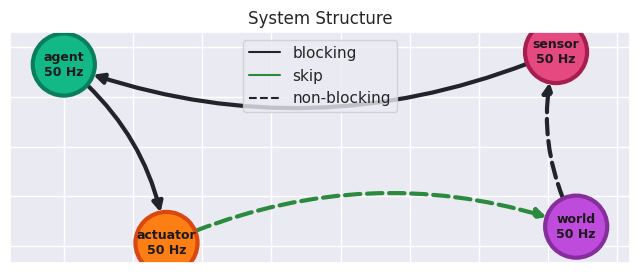

In [4]:
# @title Visualizing the System
# @markdown You can visualize the system to understand the structure of your graph.

import matplotlib.pyplot as plt

from rex.utils import plot_system


# Collect node information for visualization
node_infos = {node.name: node.info for node in [sensor, agent, actuator, world]}

# Plot the system
fig, ax = plt.subplots(figsize=(8, 3))
plot_system(node_infos, ax=ax)
ax.legend()
ax.set_title("System Structure")
plt.show()

## Graphs in Rex (`SIMULATED` and `WALL_CLOCK` runtimes)

In Rex, a **graph** is created by connecting nodes to define the flow of data and execution between them. A graph serves as the backbone for modeling systems that involve multiple interacting components, such as sensors, actuators, and agents.

### Key Components of a Graph

- **`nodes`**: The nodes that form the building blocks of the graph, each performing specific tasks like sensing, acting, or controlling.
- **`supervisor`**: A designated node that determines the step-by-step progression of the graph (more details in the next section).
- **`clock`**: Determines how time is managed in the graph. Choices include `Clock.SIMULATED` for virtual simulations and `Clock.WALL_CLOCK` for real-time applications.
- **`real_time_factor`**: Sets the speed of the simulation. It can simulate as fast as possible (`RealTimeFactor.FAST_AS_POSSIBLE`), in real-time (`RealTimeFactor.REAL_TIME`), or at any custom speed relative to real-time.

### Real-Time and Simulated Clocks

Rex provides flexible control over the simulation's timing through two main clock types and the ability to adjust the real-time factor:
1. **`Clock.SIMULATED`**: The simulation advances based on the specified delays between nodes. This mode is ideal for running simulations in a controlled environment.
2. **`Clock.WALL_CLOCK`**: The graph progresses based on real-world time. This mode is essential for real-time systems and deployments.

### Controlling Simulation Speed with `real_time_factor`

The `real_time_factor` modifies the simulation speed:
- **`RealTimeFactor.FAST_AS_POSSIBLE`**: Simulates as quickly as the system allows, constrained only by computational limits.
- **`RealTimeFactor.REAL_TIME`**: Simulates in real-time, matching the speed of real-world processes. Combine with `Clock.WALL_CLOCK` for real-time applications.
- **Custom Speed**: Any positive float value allows for custom speeds relative to real-time.

### The Role of the Supervisor Node

A critical aspect of graph design in Rex is selecting a **supervisor node**, which dictates the execution flow. The supervisor node plays a pivotal role in controlling the step-by-step progression of the graph and can alter the perspective from which the system is viewed.

As a mental model, it helps to think of the graph as dividing the nodes into two groups:
1. **Supervisor Node**: The designated node that controls the graph's execution flow.
2. **All Other Nodes**: These nodes form the environment the supervisor interacts with.

This partitioning of nodes essentially creates an **agent-environment** interface, where the supervisor node acts as the agent, and the remaining nodes represent the environment. The graph provides gym-like `.reset` and `.step` methods that mirror reinforcement learning interfaces:
- **`.reset`**: Initializes the system and returns the initial observation as would be seen by the supervisor node.
- **`.step`**: Advances the simulation by one step (i.e. steps all nodes except the supervisor) and returns the next observation.

The beauty of this design lies in its flexibility. By selecting different supervisor nodes, you can create learning environments from varying perspectives:
- **Agent as Supervisor**: Forms a traditional reinforcement learning environment.
- **Sensor as Supervisor**: Creates an interface where the `.reset` and `.step` methods return the sensor's inputs, simulating the I/O process from the sensor's viewpoint.

In [5]:
# @title Creating the Graph
# @markdown With the nodes defined and connected, we can create a graph.

from rex.asynchronous import AsyncGraph
from rex.constants import Clock, RealTimeFactor


# Create the graph by specifying the nodes and the supervisor node
graph = AsyncGraph(
    nodes=nodes,
    supervisor=agent,
    # Settings for simulating at fast as possible speed according to specified delays
    clock=Clock.SIMULATED,
    real_time_factor=RealTimeFactor.FAST_AS_POSSIBLE,
    # Settings for simulating at real-time speed according to specified delays
    # clock=Clock.SIMULATED, real_time_factor=RealTimeFactor.REAL_TIME,
    # Settings for real-world deployment
    # clock=Clock.WALL_CLOCK, real_time_factor=RealTimeFactor.REAL_TIME,
)


## Interacting with the Graph

After creating the graph, we can interact with it using the provided APIs to initialize, reset, and step through the graph.

In [6]:
# @title Initializing the Graph
# @markdown Before starting an episode, we initialize the graph's state.
# @markdown This prepares the graph for execution by initializing the parameters, states, and inputs of all nodes.
# @markdown If we must initialize in a specific order, we can specify the order of node initialization.
# @markdown We also compile ahead-of-time the step functions of all nodes to speed up execution, where we can specify the devices for each node.

# Import JAX random number generator
import jax


# Initialize the graph state
rng = jax.random.PRNGKey(0)  # Optional random number generator for reproducibility

# Start initialization with the agent node. This is important as the world's state
# depends on the initial theta and thdot sampled in agent.init_state(...)
initial_graph_state = graph.init(rng=rng, order=["agent"])

# Specify what we want to record (params, state, output) for each node,
graph.set_record_settings(params=True, inputs=False, state=True, output=True)

# Ahead-of-time compilation of all step functions
# Compile the step functions of all nodes to speed up execution.
# Specify the devices for each node, placing them on the CPU or GPU.
from rex.constants import LogLevel
from rex.utils import set_log_level


# Place all nodes on the CPU, except the agent, which is placed on the GPU (if available)
[set_log_level(LogLevel.DEBUG, n) for n in nodes.values()]  # Silence the log output
devices_step = {k: next(cpus) if k != "agent" or gpu is None else gpu for k in nodes}
graph.warmup(initial_graph_state, devices_step, jit_step=True, profile=True)  # Profile=True for profiling the step function

In [7]:
# @title Graph interaction (Gym-Like API)
# @markdown We use the graph state obtained with .init() and perform step-by-step execution with .reset() and .step().
# @markdown Finally, we get the recorded episode data for analysis.
import jax.numpy as jnp
import tqdm  # Used for progress bars


# Starts the graph with the initial state and returns the supervisor's initial step state.
# If nodes have specified `.startup` methods, they will be called here as well.
graph_state, initial_step_state = graph.reset(initial_graph_state)
step_state = initial_step_state  # The supervisor's step state
for i in tqdm.tqdm(range(300), desc="gather data"):
    # Access the last sensor message of the input buffer
    # -1 is the most recent message, -2 the second most recent, etc. up until the window size
    sensor_msg = step_state.inputs["sensor"][-1].data  # .data grabs the pytree message object
    action = jnp.array([0.5])  # Replace with actual action
    output = step_state.params.to_output(action)  # Convert the action to an output message
    # Step the graph (i.e., executes the next time step by sending the output message to the actuator node)
    graph_state, step_state = graph.step(graph_state, step_state, output)  # Step the graph with the agent's output
graph.stop()  # Stops all nodes that were running asynchronously in the background

# Get the episode data (params, delays, outputs, etc.)
record = graph.get_record()  # Gets the records of all nodes

gather data: 100%|██████████| 300/300 [00:08<00:00, 36.60it/s]


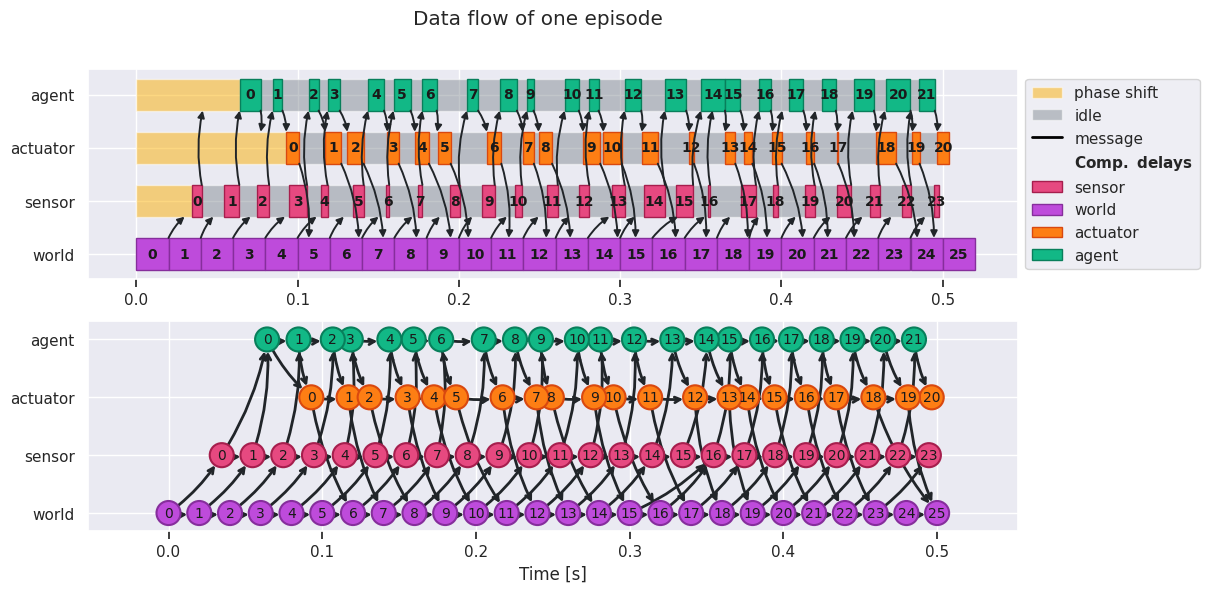

In [8]:
# @title Visualizing the Dataflow of an Episode
# @markdown We can visualize the dataflow of the episode to understand the interactions between nodes.
# @markdown The top plot shows how long each node takes to process data and forward it to the next node.
# @markdown The bottom plot provides a graph representation that will form the basis for the computational graph used for compilation.
# @markdown - Each vertex represents a step call of a node, and each edge represents message transmission between two nodes.
# @markdown - Edges between consecutive steps of the same node represent the transmission of the internal state of the node.
# @markdown - Nodes start processing after an initial phase-shift, which can be controlled in the node definition.

import supergraph  # Used for visualizing the graph

import rex.utils as rutils


# Convert the episode data to a data flow graph
df = record.to_graph()
timing_mode = "arrival"  # "arrival" or "usage"
G = rutils.to_networkx_graph(df, nodes=nodes)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
rutils.plot_graph(
    G,
    max_x=0.5,
    ax=axes[0],
    message_arrow_timing_mode=timing_mode,
    edge_linewidth=1.4,
    arrowsize=10,
    show_labels=True,
    height=0.6,
    label_loc="center",
)
supergraph.plot_graph(G, max_x=0.5, ax=axes[1])
fig.suptitle("Data flow of one episode")
axes[-1].set_xlabel("Time [s]");

In [9]:
# @title Creating a Compiled Graph
# @markdown Next, we create a compiled graph to speed up execution by pre-compiling the dataflow graph.
# @markdown This approach requires a recording of the dataflow graph during a simulation episode.
# @markdown By simulating an episode according to the exact same dataflow graph, we include the asynchronous effects of delays.

# Initialize a graph that can be compiled and enables parallelized execution
cgraph = rex.graph.Graph(nodes, nodes["agent"], df)

Growing supergraph: 100%|██████████| 301/301 [00:00<00:00, 487.16it/s, 1/1 graphs, 1210/1210 matched (67.00% efficiency, 6 nodes (pre-filtered: 6 nodes))]


In [10]:
# @title Simulating a Compiled Graph
# @markdown A compiled graph has the same API as a regular graph (init, reset, step, run).
# @markdown However, we can also simulate entire rollouts in an optimized manner.
# @markdown Here, we simulate multiple rollouts in parallel to speed up the simulation process.
num_rollouts = 10_000


# Define a function for rolling out the graph that can be compiled and executed in parallel
def rollout_fn(rng):
    # Initialize graph state
    gs = cgraph.init(rng, order=("agent",))
    # Make sure to record the states
    gs = cgraph.init_record(gs, params=False, state=True, output=False)
    # Run the graph for a fixed number of steps
    gs_final = cgraph.rollout(gs)
    # This returns a record that may only be partially filled.
    record = gs_final.aux["record"]
    is_filled = record.nodes["world"].steps.seq >= 0  # Unfilled steps are marked with -1
    return is_filled, record.nodes["world"].steps.state


# Prepare timers
timer_jit = rutils.timer(f"Vectorized evaluation of {num_rollouts} rollouts | compile", log_level=100)
timer_run = rutils.timer(f"Vectorized evaluation of {num_rollouts} rollouts | rollouts", log_level=100)

# Run the rollouts in parallel
rng, rng_rollout = jax.random.split(rng)
rngs_rollout = jax.random.split(rng_rollout, num=num_rollouts)
with timer_jit:
    rollout_fn_jv = jax.jit(jax.vmap(rollout_fn))
    rollout_fn_jv = rollout_fn_jv.lower(rngs_rollout)
    rollout_fn_jv = rollout_fn_jv.compile()
with timer_run:
    is_filled, final_states = rollout_fn_jv(rngs_rollout)
    final_states.th.block_until_ready()

# Only keep the filled rollouts (we did not run the full duration of the computation graph)
final_states = final_states[is_filled]
print(
    f"sim. eval | fps: {(num_rollouts * cgraph.max_steps) / timer_run.duration / 1e6:.0f} Million steps/s | compile: {timer_jit.duration:.2f} s | run: {timer_run.duration:.2f} s"
)

[434  ][MainThread               ][tracer              ][Vectorized evaluation of 10000 rollouts | compile] Elapsed: 4.8439 sec
[434  ][MainThread               ][tracer              ][Vectorized evaluation of 10000 rollouts | rollouts] Elapsed: 0.0998 sec
sim. eval | fps: 30 Million steps/s | compile: 4.84 s | run: 0.10 s


## Defining an Environment

To integrate your graph within a reinforcement learning environment or other systems, define an environment class that interacts with the graph. RL algorithms such as the one defined in `rex.ppo` requires an environment that implements the following methods:

### Implementing the Environment Class

- **`observation_space`**: Describes the observation space of the environment.
- **`action_space`**: Describes the action space of the environment.
- **`max_steps`**: The maximum number of step the environment can run (i.e. episode length). When using a compiled Graph, this is constrained by the length of the recorded episode.
- **`reset`**: Prepares the environment for a new episode by initializing and resetting the graph.
- **`step`**: Advances the environment by one timestep, applying the provided action and returning the new observation and reward.

In [11]:
# @title Example: Pendulum swing-up environment

from typing import Any, Dict, Union

import jax
import jax.numpy as jnp

from rex import base
from rex.examples.pendulum.agent import AgentParams
from rex.graph import Graph
from rex.rl import BaseEnv, Box, ResetReturn, StepReturn


class SwingUpEnv(BaseEnv):
    def __init__(self, graph: Graph):
        super().__init__(graph=graph)
        self._init_params = {}

    @property
    def max_steps(self) -> Union[int, jax.typing.ArrayLike]:
        """Maximum number of steps in an evaluation episode"""
        return int(3.5 * self.graph.nodes["agent"].rate)

    def set_params(self, params: Dict[str, Any]):
        """Pre-set parameters for the environment"""
        self._init_params.update(params)

    def observation_space(self, graph_state: base.GraphState) -> Box:
        cdata = self.get_observation(graph_state)
        low = jnp.full(cdata.shape, -1e6)
        high = jnp.full(cdata.shape, 1e6)
        return Box(low, high, shape=cdata.shape, dtype=cdata.dtype)

    def action_space(self, graph_state: base.GraphState) -> Box:
        params: AgentParams = graph_state.params["agent"]
        high = jnp.array([params.max_torque], dtype=jnp.float32)
        return Box(-high, high, shape=high.shape, dtype=high.dtype)

    def get_observation(self, graph_state: base.GraphState) -> jax.Array:
        # Flatten all inputs and state of the supervisor as the observation
        ss = graph_state.step_state["agent"]
        params: AgentParams = ss.params
        obs = params.get_observation(ss)
        return obs

    def reset(self, rng: jax.Array = None) -> ResetReturn:
        # Initialize the graph state
        init_gs = self.graph.init(rng=rng, params=self._init_params, order=("agent",))
        # Run the graph until the agent node
        gs, _ = self.graph.reset(init_gs)
        # Get observation
        obs = self.get_observation(gs)
        info = {}  # No info to return
        return gs, obs, info

    def step(self, graph_state: base.GraphState, action: jax.Array) -> StepReturn:
        params: AgentParams = graph_state.params["agent"]
        # Update the agent's state (i.e. action and observation history)
        new_agent = params.update_state(graph_state.step_state["agent"], action)
        # The loss_task (i.e. reward) is accumulated in the World node's step function
        # Hence, we read out the loss_task from the world node and set it to 0 before stepping
        # This is to ensure that the loss_task is only counted once
        # Note that this is not obligatory, but it's a good way to ensure that the reward is consistent in the
        # face of simulated asynchrounous effects.
        new_world = graph_state.state["world"].replace(loss_task=0.0)
        # Update the states in the graph state
        gs = graph_state.replace(state=graph_state.state.copy({"agent": new_agent, "world": new_world}))
        # Convert action to output (i.e. the one that the Agent node outputs)
        ss = gs.step_state["agent"]
        output = params.to_output(action)
        # Step the graph (i.e. all nodes except the Agent node)
        next_gs, next_ss = self.graph.step(gs, ss, output)
        # Get observation
        obs = self.get_observation(next_gs)
        info = {}
        # Read out the loss_task from the world node's state
        reward = -graph_state.state["world"].loss_task
        # Determine if the episode is truncated
        terminated = False  # Infinite horizon task
        truncated = params.tmax <= next_ss.ts  # Truncate if the time limit is reached
        # Mitigate truncation of infinite horizon tasks by adding a final reward
        # Add the steady-state solution as if the agent had stayed in the same state for the rest of the episode
        gamma = params.gamma
        reward_final = truncated * (1 / (1 - gamma)) * reward  # Assumes that the reward is constant after truncation
        reward = reward + reward_final
        return next_gs, obs, reward, terminated, truncated, info

In [12]:
# @title Example: Training a PPO agent
# @markdown We can now train a PPO agent on the defined environment.
# @markdown In fact, we do so in parallel with 5 policies to speed up training.

import functools

import rex.ppo as ppo


# Create the environment
env = SwingUpEnv(cgraph)

# Configure the PPO agent
config = ppo.Config(
    LR=0.0003261962464827655,
    NUM_ENVS=128,
    NUM_STEPS=32,
    TOTAL_TIMESTEPS=5e6,
    UPDATE_EPOCHS=8,
    NUM_MINIBATCHES=16,
    GAMMA=0.9939508937435216,
    GAE_LAMBDA=0.9712149137900143,
    CLIP_EPS=0.16413213812946092,
    ENT_COEF=0.01,
    VF_COEF=0.8015258840683805,
    MAX_GRAD_NORM=0.9630061315073456,
    NUM_HIDDEN_LAYERS=2,
    NUM_HIDDEN_UNITS=64,
    KERNEL_INIT_TYPE="xavier_uniform",
    HIDDEN_ACTIVATION="tanh",
    STATE_INDEPENDENT_STD=True,
    SQUASH=True,
    ANNEAL_LR=False,
    NORMALIZE_ENV=True,
    FIXED_INIT=True,
    OFFSET_STEP=False,
    NUM_EVAL_ENVS=20,
    EVAL_FREQ=20,
    VERBOSE=True,
    DEBUG=False,
)

# Train 5 policies in parallel
rng, rng_train = jax.random.split(rng)
rngs_train = jax.random.split(rng_train, num=5)  # Train 5 policies in parallel
train = functools.partial(ppo.train, env)
with rutils.timer("ppo | compile"):
    train_v = jax.vmap(train, in_axes=(None, 0))
    train_vjit = jax.jit(train_v)
    train_vjit = train_vjit.lower(config, rngs_train).compile()
with rutils.timer("ppo | train"):
    res = train_vjit(config, rngs_train)

[434  ][MainThread               ][tracer              ][ppo | compile       ] Elapsed: 40.6049 sec
train_steps=249856 | eval_eps=20 | return=-776.5+-0.0 | length=147+-0.0 | approxkl=0.0033
train_steps=249856 | eval_eps=20 | return=-725.1+-0.0 | length=147+-0.0 | approxkl=0.0038
train_steps=249856 | eval_eps=20 | return=-722.7+-0.0 | length=147+-0.0 | approxkl=0.0038
train_steps=249856 | eval_eps=20 | return=-1002.3+-0.0 | length=147+-0.0 | approxkl=0.0039
train_steps=249856 | eval_eps=20 | return=-1490.4+-0.0 | length=147+-0.0 | approxkl=0.0037
train_steps=499712 | eval_eps=20 | return=-696.3+-0.0 | length=147+-0.0 | approxkl=0.0028
train_steps=499712 | eval_eps=20 | return=-702.2+-0.0 | length=147+-0.0 | approxkl=0.0031
train_steps=499712 | eval_eps=20 | return=-627.2+-0.0 | length=147+-0.0 | approxkl=0.0029
train_steps=499712 | eval_eps=20 | return=-613.8+-0.0 | length=147+-0.0 | approxkl=0.0029
train_steps=499712 | eval_eps=20 | return=-686.7+-0.0 | length=147+-0.0 | approxkl=0.002

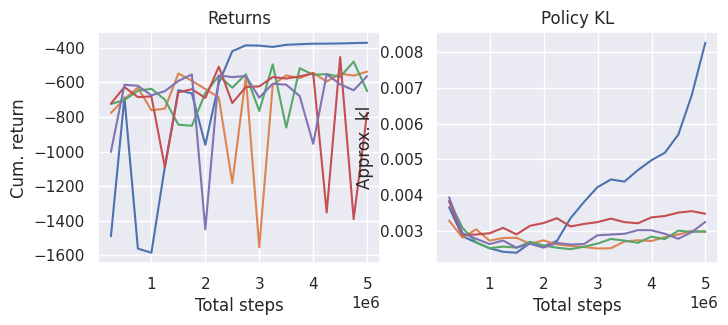

In [13]:
# @title Visualize PPO Training Progress
# @markdown The plots below show the training progress of the PPO algorithm in terms of returns and policy KL divergence.
# @markdown Note that we are not solving the swing-up task here, but rather demonstrating the training process.
# @markdown See `sim2real.ipynb` for a complete example of solving the swing-up task using PPO.

fig_ppo, axes_ppo = plt.subplots(1, 2, figsize=(8, 3))
total_steps = res.metrics["train/total_steps"].transpose()
mean, std = res.metrics["eval/mean_returns"].transpose(), res.metrics["eval/std_returns"].transpose()
axes_ppo[0].plot(total_steps, mean, label="mean")
axes_ppo[0].set_title("Returns")
axes_ppo[0].set_xlabel("Total steps")
axes_ppo[0].set_ylabel("Cum. return")
mean, std = res.metrics["train/mean_approxkl"].transpose(), res.metrics["train/std_approxkl"].transpose()
axes_ppo[1].plot(total_steps, mean, label="mean")
axes_ppo[1].set_title("Policy KL")
axes_ppo[1].set_xlabel("Total steps")
axes_ppo[1].set_ylabel("Approx. kl");